# Embeddings analysis and 2D/3D projections


An embedding is a vector that represents the word or sentences in a high-dimensional space, such that elements with similar meanings are close together in this space. Embeddings make it easy for machine learning models and other algorithms to understand the relationships between content and to perform tasks like clustering or retrieval.

In [5]:
from pathlib import Path

from dotenv import load_dotenv
from langchain_text_splitters import RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt
import numpy as np
from openai import OpenAI
import pandas as pd
import plotly.graph_objects as go
from sklearn.decomposition import PCA

## Settings

Load OpenAI API key

In [6]:
load_dotenv()

True

Define the embedding model to use

In [7]:
EMBEDDING_MODEL = "text-embedding-3-large"

## Tooling

In [8]:
# Function to create the embeddings
client = OpenAI()

def get_embeddings_raw(text: str, model: str = EMBEDDING_MODEL) -> str:
    """Get raw embeddings from OpenAi."""
    return client.embeddings.create(
           input=[text],
           model=model
        ).data[0].embedding

def get_embeddings(df: pd.DataFrame, col_name: str = "text") -> pd.DataFrame:
    """Get embedding vectors, length and norm."""
    df["embeddings"] = df[col_name].apply(get_embeddings_raw)
    df["embeddings_dim"] = df["embeddings"].apply(lambda x: len(x))
    df["embeddings_norm"] = df["embeddings"].apply(lambda x: np.linalg.norm(x))
    return df

In [9]:
def split_text(text: str, chunk_size: int = 1000, chunk_overlap: int = 200) -> list[str]:
    """"
    Split the text into chunks of the specified size and overlap.

    Parameters
    ----------
    text : str
        The text to split into chunks
    chunk_size : int
        The size of each chunk
    chunk_overlap : int
        The overlap between each chunk
    
    Returns
    -------
    chunks : list[str]
        A list of text chunks

    """
    # Create a character-based text splitter.
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n"],
    )
    # Split the input text.
    chunks = text_splitter.split_text(text)
    return chunks

In [10]:
def compute_pca(df: pd.DataFrame, col_name: str = "embeddings") -> tuple[pd.DataFrame, list]:
    """Reduce the dimension of the embeddings with PCA.
    """
    pca = PCA(n_components=3).fit(df[col_name].tolist())
    for idx, component in enumerate(pca.transform(df[col_name].tolist()).T, start=1):
        col_name = f"pca_comp_{idx}"
        df[col_name] = component
    
    labels = {
        idx: f"PCA compotent {idx} ({ratio*100:.0f} %)"
        for idx, ratio in enumerate(pca.explained_variance_ratio_, start=1)
    }
    return df, labels

In [11]:
def plot_2D_matplotlib(df: pd.DataFrame, labels=None) -> None:
    """Build 2D plot with Matplotlib."""
    categories = df["category"].unique().tolist()
    _fig, ax = plt.subplots(figsize=(6, 6))
    for category in categories:
        ax.scatter(df[df["category"] == category]["pca_comp_1"], 
                    df[df["category"] == category]["pca_comp_2"], 
                    label=category)
    ax.set_xlabel(labels[1])
    ax.set_ylabel(labels[2])
    ax.set_title("2D projection of embeddings")
    ax.legend()
    plt.show()

In [12]:
def plot_2D_plotly(df: pd.DataFrame, labels=None) -> None:
    """Build 2D plot with Plotly."""
    categories = df["category"].unique().tolist()
    fig = go.Figure()
    for category in categories:
        # Get data points
        x = df[df["category"] == category]["pca_comp_1"]
        y = df[df["category"] == category]["pca_comp_2"]
        # Get the text for hover
        hover_text = df[df["category"] == category]["text"]
        # Add points
        fig.add_trace(
            go.Scatter(
                x=x,
                y=y,
                mode="markers",
                marker=dict(size=8, colorscale="Viridis", opacity=0.8),
                name=category,
                hovertext=hover_text,
                hoverinfo="text",
            )
        )
    fig.update_layout(
        autosize=False,
        title="2D projection of embeddings",
        width=800,
        height=600,
        margin=dict(l=50, r=50, b=50, t=50, pad=10),
        xaxis=dict(title=labels[1]),
        yaxis=dict(title=labels[2]),
    )
    fig.show()

In [13]:
def plot_3D_plotly(df, labels=None) -> None:
    """Build 2D plot with Plotly."""
    categories = df["category"].unique().tolist()
    fig = go.Figure()
    for category in categories:
        # Get data points
        x = df[df["category"] == category]["pca_comp_1"]
        y = df[df["category"] == category]["pca_comp_2"]
        z = df[df["category"] == category]["pca_comp_3"]
        # Set the hover text
        hover_text = df[df["category"] == category]["text"]
        # Add points
        fig.add_trace(
            go.Scatter3d(
                x=x,
                y=y,
                z=z,
                mode="markers",
                marker=dict(size=5, colorscale="Viridis", opacity=0.8),
                name=category,
                hovertext=hover_text,
                hoverinfo="text",
            )
        )
    fig.update_layout(
        autosize=False,
        title="3D projection of embeddings",
        width=800,
        height=500,
        margin=dict(l=10, r=10, b=50, t=50, pad=10),
        scene=dict(
            xaxis=dict(title=component_labels[1]),
            yaxis=dict(title=component_labels[2]),
            zaxis=dict(title=component_labels[3]),
        ),
    )
    fig.show()

## Exploratory Data Analysis

### Load data

In [15]:
# Import the data
pd.set_option("display.max_colwidth", None)
df = pd.read_csv("../data/embeddings_analysis/sentence.csv", sep=",")
df

,category,text
0,Programmation,Python est un langage de programmation interprété dynamique et polyvalent.
1,Programmation,Les développeurs utilisent souvent Python pour l'analyse de données en raison de ses bibliothèques robustes comme Pandas et NumPy.
2,Programmation,La syntaxe claire et concise de Python en fait un excellent choix pour les débutants en programmation.
3,Programmation,Python est un langage polyvalent utilisé dans des domaines allant du développement de jeux à l'automatisation des tâches système.
4,Programmation,Les grandes entreprises telles que Google Facebook et Netflix font largement usage de Python dans leur infrastructure logicielle.
5,Programmation,Les listes en Python sont des structures de données flexibles et polyvalentes permettant de stocker et de manipuler des collections d'éléments.
6,Programmation,La vaste bibliothèque standard de Python offre des modules pour pratiquement toutes les tâches courantes de programmation.
7,Programmation,Les frameworks web populaires comme Django et Flask sont écrits en Python permettant un développement rapide et efficace des applications web.
8,Animaux,Le python royal est une espèce de serpent non venimeux originaire d'Afrique.
9,Animaux,Les pythons peuvent avaler des proies entières grâce à leur mâchoire extensible.


### Get embeddings

In [16]:
# Get embeddings, dimension and norm
pd.set_option("display.max_colwidth", 150)

df = get_embeddings(df, col_name="text")

In [17]:
df.head(3)

,category,text,embeddings,embeddings_dim,embeddings_norm
0,Programmation,Python est un langage de programmation interprété dynamique et polyvalent.,"[-0.019774435088038445, 0.00032860145438462496, -0.012051371857523918, 0.02634328044950962, 0.023457741364836693, 0.013112232089042664, 0.01963864...",3072,1.0
1,Programmation,Les développeurs utilisent souvent Python pour l'analyse de données en raison de ses bibliothèques robustes comme Pandas et NumPy.,"[-0.016681581735610962, -0.016789712011814117, -0.019168581813573837, 0.015865689143538475, 0.04376334697008133, -0.005421268288046122, -0.0012097...",3072,1.0
2,Programmation,La syntaxe claire et concise de Python en fait un excellent choix pour les débutants en programmation.,"[0.011791401542723179, 0.007366125006228685, -0.002037587808445096, 0.01833595708012581, -0.00405416963621974, 0.006133769638836384, 0.01459220983...",3072,1.0


The dimension of the embeddings is 3072, that is coherent with the [documentation](https://platform.openai.com/docs/guides/embeddings/embeddings) for the model used.

The norm of embeddings vector is 1 for all the embeddings, which means that the embeddings are normalized. This is a common practice in machine learning to normalize the embeddings to make the training process easier.

### PCA

In [18]:
df, component_labels = compute_pca(df, col_name="embeddings")
df.head(3)

,category,text,embeddings,embeddings_dim,embeddings_norm,pca_comp_1,pca_comp_2,pca_comp_3
0,Programmation,Python est un langage de programmation interprété dynamique et polyvalent.,"[-0.019774435088038445, 0.00032860145438462496, -0.012051371857523918, 0.02634328044950962, 0.023457741364836693, 0.013112232089042664, 0.01963864...",3072,1.0,0.466707,0.033992,0.196265
1,Programmation,Les développeurs utilisent souvent Python pour l'analyse de données en raison de ses bibliothèques robustes comme Pandas et NumPy.,"[-0.016681581735610962, -0.016789712011814117, -0.019168581813573837, 0.015865689143538475, 0.04376334697008133, -0.005421268288046122, -0.0012097...",3072,1.0,0.400980,-0.237609,-0.050742
2,Programmation,La syntaxe claire et concise de Python en fait un excellent choix pour les débutants en programmation.,"[0.011791401542723179, 0.007366125006228685, -0.002037587808445096, 0.01833595708012581, -0.00405416963621974, 0.006133769638836384, 0.01459220983...",3072,1.0,0.411081,-0.028985,0.045768


### 2D projection of embeddings

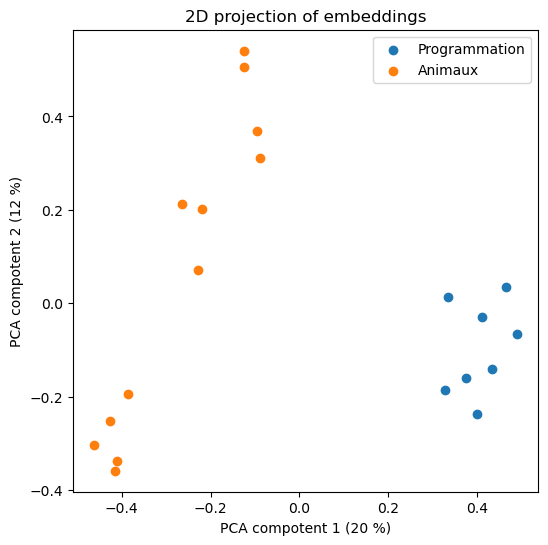

In [19]:
# with Matplotlib
plot_2D_matplotlib(df, labels=component_labels)

# with Plotly
plot_2D_plotly(df,  labels=component_labels)

### 3D projection of embeddings

In [20]:
# With Plotly.
plot_3D_plotly(df, labels=component_labels)

## Application to the content of Python course chapters

The question is:

> **Can we correctly separate the chunks of these 4 chapters or are they a bit mixed up?**

Markdown files should be in `../data/markdown_raw`

In [21]:
# Path to chapters
markdown_path = "../data/markdown_raw"

# Define chapters
chapters = [
    {"name": "Affichage", "filename": "03_affichage.md"},
    {"name": "Listes", "filename": "04_listes.md"},
    {"name": "Fonctions", "filename": "09_fonctions.md"},
    {"name": "Jupyter", "filename": "18_jupyter.md"},
]

In [22]:
# Get chapters content and extract chunks.
chapter_chunks = {}

for chapter in chapters:
    f_in = Path(markdown_path) / chapter["filename"]
    content = f_in.read_text()
    chapter_chunks[chapter["name"]] = split_text(content, chunk_size=1000, chunk_overlap=200)

for chapter, chunks in chapter_chunks.items():
    print(f"Chapter name: {chapter}")
    print(f"Number of chunks: {len(chunks)}")
    print("\n")

Chapter name: Affichage
Number of chunks: 30


Chapter name: Listes
Number of chunks: 14


Chapter name: Fonctions
Number of chunks: 33


Chapter name: Jupyter
Number of chunks: 14




In [23]:
df = pd.DataFrame(columns=["category", "text"])
for chapter, chunks in chapter_chunks.items():
    df = pd.concat(
        [df,pd.DataFrame({"category": [chapter]*len(chunks), "text": chunks})],
        ignore_index=True
    )
df.sample(10)

,category,text
33,Listes,"puis lui ajouter deux éléments, l'un après l'autre, d'abord avec la concaténation :\n\n```python\n>>> a = a + [15]\n>>> a\n[15]\n>>> a = a + [-5]\..."
28,Affichage,### Poly-A\n\nGénérez une chaîne de caractères représentant un brin d'ADN poly-A (c'est-à-dire qui ne contient que des bases A) de 20 bases de lon...
40,Listes,"```python\n>>> enclos1 = [""girafe"", 4]\n>>> enclos2 = [""tigre"", 2]\n>>> enclos3 = [""singe"", 5]\n>>> zoo = [enclos1, enclos2, enclos3]\n>>> zoo\n[[..."
60,Fonctions,"## Variables locales et variables globales\n\nLorsqu'on manipule des fonctions, il est essentiel de bien comprendre comment se comportent les vari..."
0,Affichage,"# Affichage\n\n## La fonction `print()`\n\nDans le chapitre 1, nous avons rencontré la fonction `print()` qui affiche une chaîne de caractères (le..."
35,Listes,"```python\n>>> animaux[-4]\n'girafe'\n```\n\nDans ce cas, on utilise plutôt `animaux[0]`.\n\n\n## Tranches\n\nUn autre avantage des listes est la ..."
24,Affichage,"Le formattage avec la méthode `.format()` se rapproche de la syntaxe des *f-strings* (accolades, deux-points), mais présente l'inconvénient -- com..."
15,Affichage,"Une remarque importante, si on ne met pas de variable à formater entre les accolades dans une *f-string*, cela conduit à une erreur :\n\n```python..."
76,Fonctions,![Illustration de la distance à l'origine.](img/sin2ori.png){ #fig:sin2ori width=60% }\n\nVotre programme générera un fichier `sin2ori.dat` qui co...
21,Affichage,"La syntaxe est légèrement différente. Le symbole `%` est d'abord appelé dans la chaîne de caractères (dans l'exemple ci-dessus `%d`, `%d` et `%.2f..."


### Get embeddings

In [24]:
df = get_embeddings(df, col_name="text")

In [25]:
df.head(3)

,category,text,embeddings,embeddings_dim,embeddings_norm
0,Affichage,"# Affichage\n\n## La fonction `print()`\n\nDans le chapitre 1, nous avons rencontré la fonction `print()` qui affiche une chaîne de caractères (le...","[0.013736422173678875, 0.004966924898326397, 0.0008459985256195068, 0.0354435071349144, -0.02676538936793804, -0.04362640529870987, 0.001245415885...",3072,1.0
1,Affichage,"Ligne 4. L'effet de l'argument `end=""""` est que les trois chevrons `>>>` se retrouvent collés après la chaîne de caractères `""Hello world!""`.\n\nU...","[0.019677618518471718, -0.0047981515526771545, -0.009469276294112206, 0.04734638333320618, -0.005756627302616835, -0.025128226727247238, -0.017829...",3072,1.0
2,Affichage,"```python\n>>> x = 32\n>>> nom = ""John""\n>>> print(nom, ""a"", x, ""ans"")\nJohn a 32 ans\n```\n\nPython a écrit une phrase complète en remplaçant les...","[0.040503136813640594, -0.00623307516798377, -0.011897352524101734, 0.046451814472675323, 0.01618703454732895, -0.006665598135441542, 0.0090296640...",3072,1.0


### PCA

In [26]:
df, component_labels = compute_pca(df, col_name="embeddings")
df.head(3)

,category,text,embeddings,embeddings_dim,embeddings_norm,pca_comp_1,pca_comp_2,pca_comp_3
0,Affichage,"# Affichage\n\n## La fonction `print()`\n\nDans le chapitre 1, nous avons rencontré la fonction `print()` qui affiche une chaîne de caractères (le...","[0.013736422173678875, 0.004966924898326397, 0.0008459985256195068, 0.0354435071349144, -0.02676538936793804, -0.04362640529870987, 0.001245415885...",3072,1.0,0.025394,-0.009311,-0.035495
1,Affichage,"Ligne 4. L'effet de l'argument `end=""""` est que les trois chevrons `>>>` se retrouvent collés après la chaîne de caractères `""Hello world!""`.\n\nU...","[0.019677618518471718, -0.0047981515526771545, -0.009469276294112206, 0.04734638333320618, -0.005756627302616835, -0.025128226727247238, -0.017829...",3072,1.0,0.138774,-0.062398,0.046804
2,Affichage,"```python\n>>> x = 32\n>>> nom = ""John""\n>>> print(nom, ""a"", x, ""ans"")\nJohn a 32 ans\n```\n\nPython a écrit une phrase complète en remplaçant les...","[0.040503136813640594, -0.00623307516798377, -0.011897352524101734, 0.046451814472675323, 0.01618703454732895, -0.006665598135441542, 0.0090296640...",3072,1.0,0.172856,-0.040931,0.048301


### 2D projection of embeddings

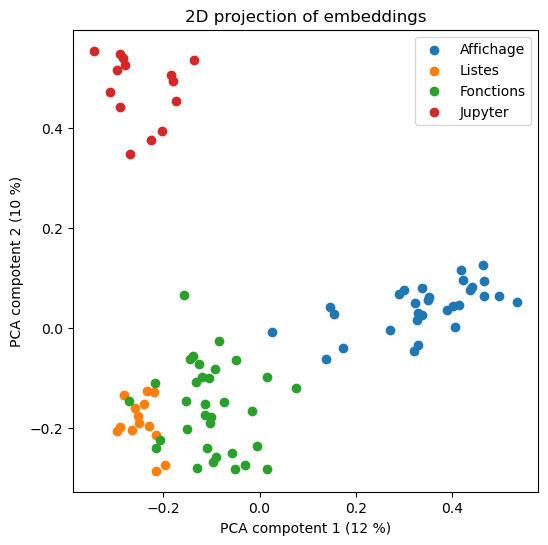

In [27]:
# with Matplotlib
plot_2D_matplotlib(df, labels=component_labels)

# with Plotly
plot_2D_plotly(df,  labels=component_labels)

### 3D projection of embeddings

In [28]:
# With Plotly.
plot_3D_plotly(df, labels=component_labels)

## Package versions

In [1]:
%load_ext watermark
# Python implementation and version, and machine architecture
%watermark
# Versions for jupyterlab, imported packages and watermark itself
%watermark --packages jupyterlab,sklearn,langchain_text_splitters,openai,matplotlib,plotly --iversions --watermark
# Name of conda environment
%watermark --conda

Last updated: 2024-06-25T16:31:41.747933+02:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 6.5.0-41-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 6
Architecture: 64bit

jupyterlab              : 4.0.11
sklearn                 : 1.4.2
langchain_text_splitters: 0.2.1
openai                  : 1.35.3
matplotlib              : 3.8.4
plotly                  : 5.22.0

Watermark: 2.4.3

conda environment: biopyassistant-sandbox-env

